# Korteweg-de-Vries : Solveur général


On cherche à résoudre l'équation de Korteweg-de-Vries écrite sous la forme suivante sur un domaine périodique :

$$
\frac{\partial u(x,t)}{\partial t} + \eta u  \frac{\partial u(x,t)}{\partial x} + \mu^2 \frac{\partial^3 u(x,t)}{\partial x^3} = 0 \quad , \quad (x,t) \in [0,L] \times [0,T]\quad, \quad \eta, \mu \in \mathbf{R}
$$


afin de déterminer numériquement sa solution appelée soliton.


À partir du schéma d'intégration proposé dans le document de recherche, on isole le terme en n+1 du reste. On obtient l'expression suivante que l'on pourra itérer dans notre code:


$$
u_{j-1}^{n+1} =  - u_{j+1}^n + u_{j+1}^{n-1} + u_{j-1}^n - \underbrace{\dfrac{\mu^2 d t}{d x^3} \left (  u_{j+2}^n-2u_{j+1}^n + 2u_{j-1}^n - u_{j-2}^n \right )}_{Terme~dispersif}  - \underbrace{\dfrac{1}{3}\dfrac{\eta d t}{d x} \left ( u_{j+1}^n + u_{j}^n + u_{j-1}^n \right )\left ( u_{j+1}^n - u_{j-1}^n \right )}_{Terme~non-linéaire}
$$

On utilise une méthode de simulation semi-implicite.

En notant $S = \dfrac{\mu^2 \delta t}{\delta x^3} \ $ et $Q = \dfrac{1}{3}\dfrac{\eta \delta t}{\delta x} \ $

On obtient:

$$
u_{j-1}^{n+1} =  u_{j+1}^{n-1} + Su_{j-2}^n + (1-2S)u_{j-1}^n + (2S-1)u_{j+1}^n - Su_{j+2}^n - Q(u_{j+1}^n + u_j^n + u_{j-1}^n)(u_{j+1}^n - u_{j-1}^n)
$$

In [1]:
!pip install animatplot

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for animatplot: filename=animatplot-0.4.3-py3-none-any.whl size=16379 sha256=19140e3277d8d456f1e35e27e157a2190e3399dbbc1693839e60c8a3a9b7e02d
  Stored in directory: c:\users\hacen\appdata\local\pip\cache\wheels\e1\4a\3a\c7abf48049ebf15d3972a3f7dafd8b7d8d1a798bd4f4cab4c2
Successfully built animatplot


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML, Image

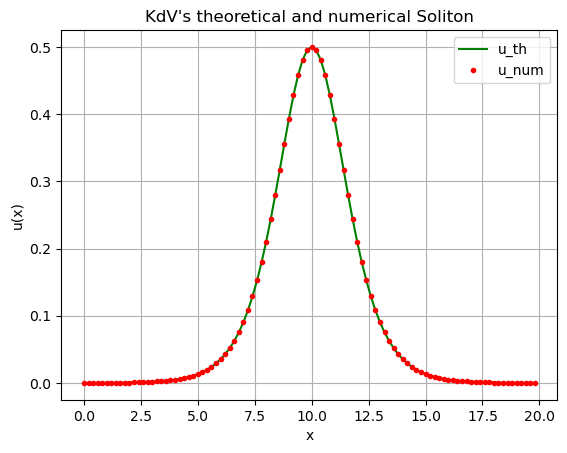

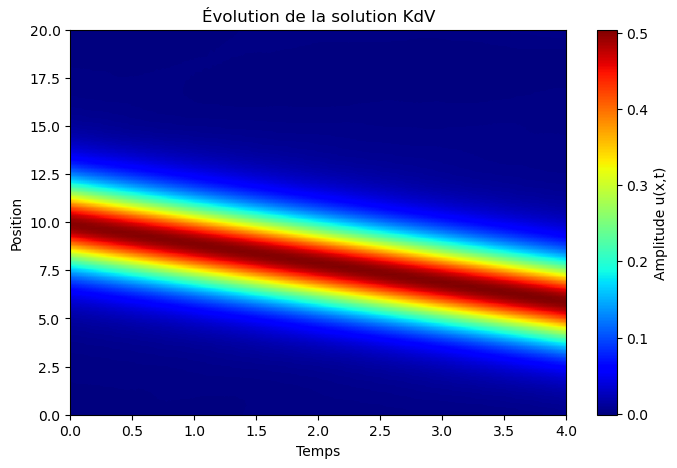

In [6]:
# mu : coef associé au terme dispersif
    # eta : coef associé au terme non-linéaire

def solveur_KdV_AYH(L, T, M, N, eta, mu, c):
    # Paramètres de discrétisation
    dx = L / M
    dt = T / N

    # S et Q
    S = mu**2 * dt / dx**3
    Q = (1 / 3) * eta * dt / dx

    # Maillage espace et temps
    x = np.linspace(0, L - dx, M)
    t = np.linspace(0, T, N + 1)

    # Initialisation de la solution u
    u = np.zeros((M, N + 1))

    # Forme théorique du soliton (condition initiale)
    def CI(x, t, c, L):
        return 0.5 * c / np.cosh((np.sqrt(c) / (2 * mu)) * (x - (L / 2) - c * t))**2

    u[:, 0] = CI(x, 0, c, L)


    def periodic_idx(j, M):
    #Correction des indices périodiques j-2, j-1, j+1, j+2 pour un indice j donné
      jm2 = (j - 2) % M
      jm1 = (j - 1) % M
      jp1 = (j + 1) % M
      jp2 = (j + 2) % M
      return jm2, jm1, jp1, jp2

    # Calcul de u pour n=1 (premier pas)
    for j in range(M):
        jm2, jm1, jp1, jp2 = periodic_idx(j, M)
        u[j, 1] = u[j, 0] + dt * (-Q / 2 * ((u[jp1, 0] + u[j, 0] + u[jm1, 0]) *
                                             (u[jp1, 0] - u[jm1, 0])) -
                                  S / 2 * (u[jp2, 0] - 2 * u[jp1, 0] +
                                           2 * u[jm1, 0] - u[jm2, 0]))

    # Boucle principale pour n >= 2
    for n in range(1, N):
        for j in range(M):
            jm2, jm1, jp1, jp2 = periodic_idx(j, M)

            u[jm1, n + 1] = (u[jp1, n - 1] + S * (u[jm2, n] - u[jp2, n]) +
                             (2 * S - 1) * (u[jp1, n] - u[jm1, n]) -
                             Q * (u[jp1, n] + u[j, n] + u[jm1, n]) *
                             (u[jp1, n] - u[jm1, n]))

    return x, t, u

def kdv_exact(x,t,c,L):
    u_th = 0.5*c/np.cosh((np.sqrt(c)/(2*mu))*(x-(L/2)-c*t))**2
    return u_th


# Paramètres de simulation
L, T, M, N, eta, mu, c = 20, 4, 100, 1000, 6, 1, 1
x, t, u = solveur_KdV_AYH(L, T, M, N, eta, mu, c)

# Affichage 2D de la solution à l'instant initial t=0
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line1, = ax.plot(x, kdv_exact(x,0,c,L),'-', c="g", label='u_th')
line2, = ax.plot(x, u[:,0],'.', c='r', label='u_num')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title("KdV's theoretical and numerical Soliton")
ax.grid(True)
ax.legend(loc='upper right')

# Visualisation rapide de la solution
plt.figure(figsize=(8, 5))
plt.imshow(u, aspect='auto', extent=[0, T, 0, L], cmap='jet')
plt.colorbar(label="Amplitude u(x,t)")
plt.xlabel("Temps")
plt.ylabel("Position")
plt.title("Évolution de la solution KdV")
plt.show()

## Animation

Traçage...


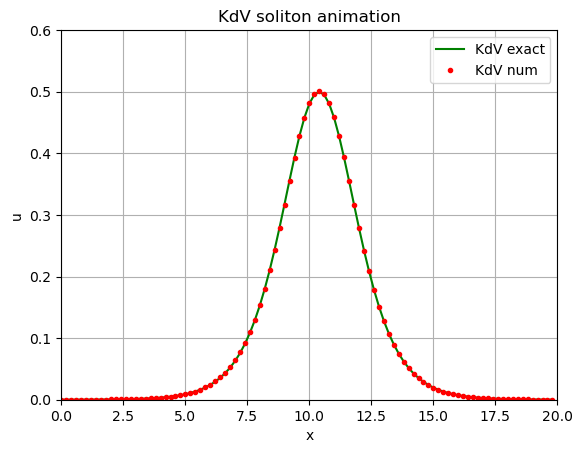

In [7]:

%matplotlib inline
import animatplot as amp
import os

def kdv_exact(x,t,c,L):
    u_th = 0.5*c/np.cosh((np.sqrt(c)/(2*mu))*(x-(L/2)-c*t))**2
    return u_th

dx = L/M
dt = T/N
t=np.linspace(0,T,N)

fig, ax = plt.subplots()
plt.xlabel("x")
plt.ylabel("u")
ax.set_xlim((0, 20))
ax.set_ylim((0, 0.6))
ax.grid(True)

line1, = ax.plot([], [], 'g')
line2, = ax.plot([], [],'.', color="r")

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2,)

def animate(i):
    ax.set_title('KdV soliton animation')
    x=np.linspace(0,L-dx,M)
    y1 = kdv_exact(x,i*dt,c,L)
    y2 = u[:,i]
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    return (line1, line2,)

line1.set_label("KdV exact")
line2.set_label("KdV num")
ax.legend()

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= range(0,100), interval=10, blit=True)
print("Traçage...")
rc("animation", html='jshtml')
anim

#On voit que les solitons (numérique et théorique) avancent en même temps mais sur une petite distance seulement
#Ceci s'explique par la vitesse c=1 prise qui est trop faible pour que le soliton parcous une grande distance compte tenu du temps de l'animation
#Toutefois en prenant une vitesse de plus en plus grande, le soliton numérique devient instable, ce qui met en évidence une limite du schéma utilisé
